### This is a playground to experiment code

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
from dot import viz
import torch
import random

from typing import Union

In [2]:
a = 5
b = 9
c = 10

y = a * b + c

print(y)

55


In [75]:
class Value:
    # data should be simple numeric value (e.g. int or float)
    def __init__(self, data, prevs=[], ops='', label=''):
        self.data = data
        self.prevs = prevs
        self.ops = ops
        self.grad = 0.0
        self.label = label
        self._backward = lambda: None

    def __repr__(self):
        return str(f'Value(data: {self.data})')

    def __str__(self):
        return self.__repr__()

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        result = Value(self.data + other.data, [self, other], '+')

        def add_backward():
            self.grad += 1.0 * result.grad
            other.grad += 1.0 * result.grad
        result._backward = add_backward
        return result

    def __sub__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        result = Value(self.data - other.data, [self, other], '-')

        def sub_backward():
            self.grad += 1.0 * result.grad
            other.grad += -1.0 * result.grad
        result._backward = sub_backward
        return result

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        result = Value(self.data * other.data, [self, other], '*')

        def mul_backward():
            self.grad += other.data * result.grad
            other.grad += self.data * result.grad
        result._backward = mul_backward

        return result

    def __truediv__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        result = Value(self.data / other.data, [self, other], '/')

        def truediv_backward():
            self.grad += math.pow(other.data, -1) * result.grad
            other.grad += -self.data * \
                math.pow(other.data, -2) * result.grad
        result._backward = truediv_backward

        return result

    def __pow__(self, other, modulo=None):
        other = other if isinstance(other, Value) else Value(other)
        result = Value(math.pow(self.data, other.data), [self, other], '**')

        def pow_backward():
            self.grad += other.data * \
                math.pow(self.data, other.data - 1) * result.grad
        result._backward = pow_backward

        return result

    def __radd__(self, other):
        return Value(other) + self

    def __rsub__(self, other):
        return Value(other) - self

    def __rmul__(self, other):
        return Value(other) * self

    def __rtruediv__(self, other):
        return Value(other) / self

    def __rpow__(self, other):
        return Value(other) ** self

    def _zero_grad(self):
        self.grad = 0

    def exp(self):
        exp = math.exp(self.data)
        result = Value(exp, [self], 'exp')

        def exp_backward():
            self.grad += exp * result.grad
        result._backward = exp_backward

        return result

    def backward(self):
        self.grad = 1.0
        visited = set()
        topo = []

        def DFS(cur):
            if cur in visited:
                return
            visited.add(cur)
            for prev in cur.prevs:
                DFS(prev)
            topo.append(cur)

        DFS(self)
        for node in reversed(topo):
            node._backward()

    def id(self):
        return str(id(self))

In [8]:
a = Value(5, label='a')
b = Value(9, label='b')
c = Value(10, label='c')
e = Value(11, label='e')
f = Value(15, label='f')
d = a * b
d.label = 'd'
g = e / f
g.label = 'g'
y = d + c - g
y.label = 'y'

y.backward()

print(y)
print(f'a.grad: {a.grad}')
print(f'b.grad: {b.grad}')
print(f'c.grad: {c.grad}')
print(f'e.grad: {e.grad}')
print(f'f.grad: {f.grad}')

Value(data: 54.266666666666666)
a.grad: 9.0
b.grad: 5.0
c.grad: 1.0
e.grad: -0.06666666666666667
f.grad: 0.04888888888888889


In [7]:
at = torch.tensor(5.0, requires_grad=True)
bt = torch.tensor(9.0, requires_grad=True)
ct = torch.tensor(10.0, requires_grad=True)
et = torch.tensor(11.0, requires_grad=True)
ft = torch.tensor(15.0, requires_grad=True)

dt = at * bt
yt = dt + ct - et / ft

yt.backward()

print(f'yt: {yt}')
print(f'at.grad: {at.grad}')
print(f'bt.grad: {bt.grad}')
print(f'ct.grad: {ct.grad}')
print(f'et.grad: {et.grad}')
print(f'ft.grad: {ft.grad}')

yt: 54.266666412353516
at.grad: 9.0
bt.grad: 5.0
ct.grad: 1.0
et.grad: -0.06666667014360428
ft.grad: 0.04888888821005821


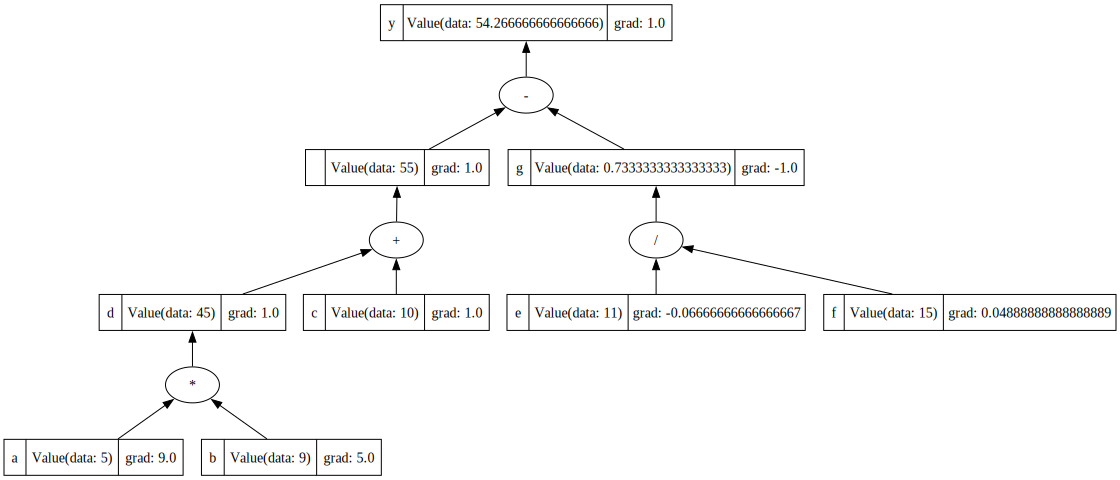

In [9]:
dot = viz.generate_graph(y)
dot

In [468]:
at = torch.tensor(5.0, requires_grad=True)
bt = torch.tensor(9.0, requires_grad=True)
ct = torch.tensor(10.0, requires_grad=True)
et = torch.tensor(11.0, requires_grad=True)
ft = torch.tensor(15.0, requires_grad=True)

yt = at * bt + ct - et / ft + at * ct**2

yt.backward()

print(f'yt: {yt}')
print(f'at.grad: {at.grad}')
print(f'bt.grad: {bt.grad}')
print(f'ct.grad: {ct.grad}')
print(f'et.grad: {et.grad}')
print(f'ft.grad: {ft.grad}')

yt: 554.2666625976562
at.grad: 109.0
bt.grad: 5.0
ct.grad: 101.0
et.grad: -0.06666667014360428
ft.grad: 0.04888888821005821


In [12]:
a = Value(5, label='a')
b = Value(9, label='b')
c = Value(10, label='c')
e = Value(11, label='e')
f = Value(15, label='f')
y = a * b + c - e / f + a * c**2
y.label = 'y'

y.backward()

print(y)
print(f'a.grad: {a.grad}')
print(f'b.grad: {b.grad}')
print(f'c.grad: {c.grad}')
print(f'e.grad: {e.grad}')
print(f'f.grad: {f.grad}')

Value(data: 554.2666666666667)
a.grad: 109.0
b.grad: 5.0
c.grad: 101.0
e.grad: -0.06666666666666667
f.grad: 0.04888888888888889


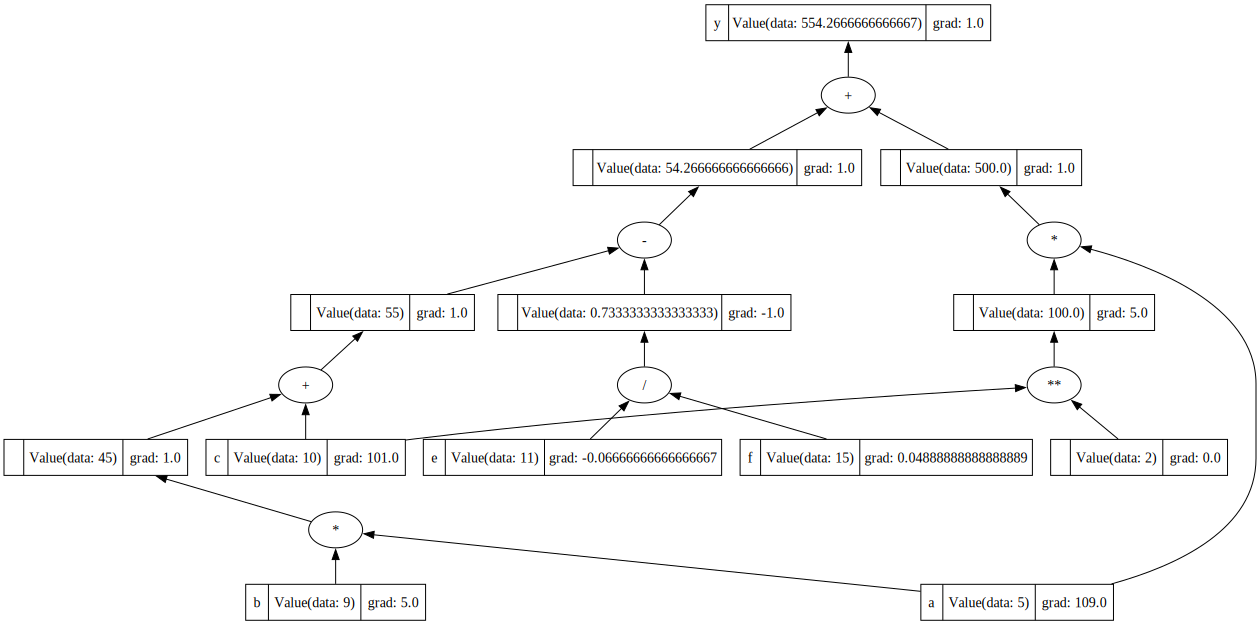

In [36]:
dot = viz.generate_graph(y)
dot

In [18]:
at = torch.tensor(5.0, requires_grad=True)
(at*2).exp()

tensor(22026.4648, grad_fn=<ExpBackward0>)

In [19]:
a = Value(5)
(a*Value(2)).exp()

Value(data: 22026.465794806718)

In [20]:
at = torch.tensor(5.0, requires_grad=True)
yt = (at*2).exp()
yt.backward()
at.grad

tensor(44052.9297)

In [22]:
a = Value(5)
y = (a*Value(2)).exp()
y.backward()
a.grad

44052.931589613436

In [72]:
def tanh(x):
    exp = math.exp(x.data * 2)
    out = (exp - 1) / (exp + 1)
    result = Value(out, prevs=[x], ops='tanh')

    def tanh_backward():
        x.grad = 1 - out ** 2
    result._backward = tanh_backward
    return result


def tanh_raw(x):
    x2exp = (x * Value(2)).exp()
    return (x2exp - Value(1)) / (x2exp + Value(1))

In [74]:
a = Value(3, label='a')
y = tanh(a)
y.label = 'y'
print(y)
y.backward()
print(a.grad)
print(1 - y.data ** 2)

Value(data: 0.9950547536867305)
0.009866037165440211
0.009866037165440211


In [37]:
at = torch.tensor(3.0, requires_grad=True)
yt = torch.tanh(at)
print(yt)
yt.backward()
print(at.grad)

tensor(0.9951, grad_fn=<TanhBackward0>)
tensor(0.0099)


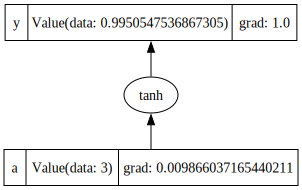

In [55]:
dot = viz.generate_graph(y)
dot

In [59]:
a = Value(5)
y1 = 1 - a
y2 = 1 + a

print(y1)
print(y2)

Value(data: -4)
Value(data: 6)


In [61]:
a = Value(5)
y = 10 * a

print(y)

Value(data: 50)


In [64]:
a = Value(5)
y = 10 / a

print(y)

Value(data: 2.0)


In [71]:
a = Value(5)
y = 10 ** a

print(y)

Value(data: 100000.0)


In [567]:
# loss function
# MSE
def mse_loss(y_hat, y):
    return sum([(yh - ys) ** 2 for yh, ys in zip(y_hat, y)]) / len(y_hat)


y_hat = [0, 1, 0, 1]
y = [1, 1, 0, 0]
print(mse_loss(y_hat, y))

0.5


In [451]:
mse = torch.nn.MSELoss()

predicted = torch.tensor([0, 1, 0, 1], dtype=torch.float32)
target = torch.tensor([1, 1, 0, 0], dtype=torch.float32)

print(mse(predicted, target))

tensor(0.5000)


In [525]:
np.random.normal(2, 0.1)

1.921617268727721

[6.922510971296676, 10.048341015966136, 12.899810824837099, 15.905799001979489]


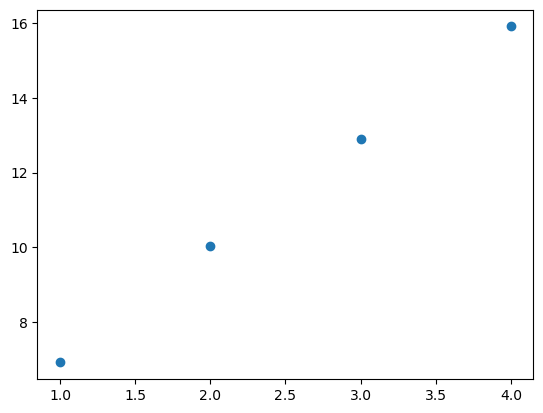

In [626]:
# linear regression with 1 input
w = Value(1.0, label='w')
b = Value(0, label='b')

w_gt = 3.0
b_gt = 2.0

X = [i for i in range(1, 5)]
y = [ w_gt * x + b_gt + np.random.normal(0, 0.1) for x in X]

print(y)
plt.scatter(X, y)


In [647]:
def forward(X):
    return [w * x + b for x in X]

def training_step():
    lr = 0.1

    y_hat = forward(X)
    loss = mse_loss(y_hat, y)
    print(loss)

    w._zero_grad()
    b._zero_grad()

    loss.backward()

    w.data -= lr * w.grad
    b.data -= lr * b.grad

for i in range(10):
    training_step()

Value(data: 0.003358920541504696)
Value(data: 0.0033493607713579506)
Value(data: 0.003340364852782308)
Value(data: 0.0033318995288494674)
Value(data: 0.0033239335041808974)
Value(data: 0.00331643732925309)
Value(data: 0.00330938329152615)
Value(data: 0.0033027453129925426)
Value(data: 0.003296498853770455)
Value(data: 0.003290620821382294)


Value(data: 2.9879517525450625) Value(data: 3.970795039254429)


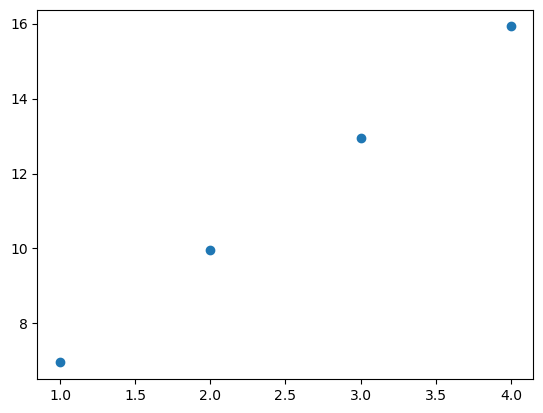

In [649]:
y_hat = forward(X)

print(w, b)

plt.scatter(X, [yh.data for yh in y_hat])

In [465]:
# simple linear regression with 3 input features


w0 = Value(random.random(), label='w0')
w1 = Value(random.random(), label='w1')
w2 = Value(random.random(), label='w2')
b = Value(0, label='b')

W = [w0, w1, w2]

w0gt = Value(random.random(), label='w0gt')
w1gt = Value(random.random(), label='w1gt')
w2gt = Value(random.random(), label='w2gt')
bgt = Value(0, label='bgt')

W_gt = [w0gt, w1gt, w2gt]


def forward(x, W, b):
    o = W[0] * x[0] + W[1] * x[1] + W[2] * x[2] + b
    return tanh(o)


X = [[2.0, -1.0, 3.0], [1.0, 5.0, -2.0], [1.0, -0.5, 4.0], [-1.0, -2.5, 2.0]]
y = [0.8, 0.7, 0.9, -0.2]

# for x in X:
#     y.append(forward(x, W_gt, bgt))
# print(y)

In [466]:
def training_step():
    y_hat = []

    for x in X:
        y_hat.append(forward(x, W, b))

    loss = mse_loss(y_hat, y)

    print(f'loss: {loss.data}')

    for w in W:
        w._zero_grad()
    b._zero_grad()


    loss.backward()

    # for p in params:
    #     print(f'{p.label}.grad: {p.grad}')

    for w in W:
        w.data -= 0.01 * w.grad
    b.data -= 0.01 * b.grad

    print('----')


for i in range(300):
    training_step()

loss: 0.10777574050555494
----
loss: 0.11342139188880845
----
loss: 0.11854365344387564
----
loss: 0.1231918731204979
----
loss: 0.12741413417493497
----
loss: 0.13125544052979396
----
loss: 0.13475688355469795
----
loss: 0.13795539626564007
----
loss: 0.14088384101893306
----
loss: 0.14357127219762783
----
loss: 0.1460432779083855
----
loss: 0.14832234454417711
----
loss: 0.15042821288637173
----
loss: 0.15237820955631665
----
loss: 0.1541875466434977
----
loss: 0.15586958754920469
----
loss: 0.15743607996893577
----
loss: 0.158897358425995
----
loss: 0.16026251944762387
----
loss: 0.161539572710951
----
loss: 0.162735571514558
----
loss: 0.16385672591351036
----
loss: 0.16490850191865553
----
loss: 0.16589571043305418
----
loss: 0.1668225902452183
----
loss: 0.16769289067355397
----
loss: 0.16850996178049021
----
loss: 0.16927686418049162
----
loss: 0.16999651766047005
----
loss: 0.170671920500507
----
loss: 0.17130649398617012
----
loss: 0.17190464768067037
----
loss: 0.172472737377

In [463]:
for x in X:
    print(forward(x, W, b))

Value(data: -0.9968846061036694)
Value(data: 0.9999955844451857)
Value(data: -0.9972442294259928)
Value(data: -0.9997358880682766)


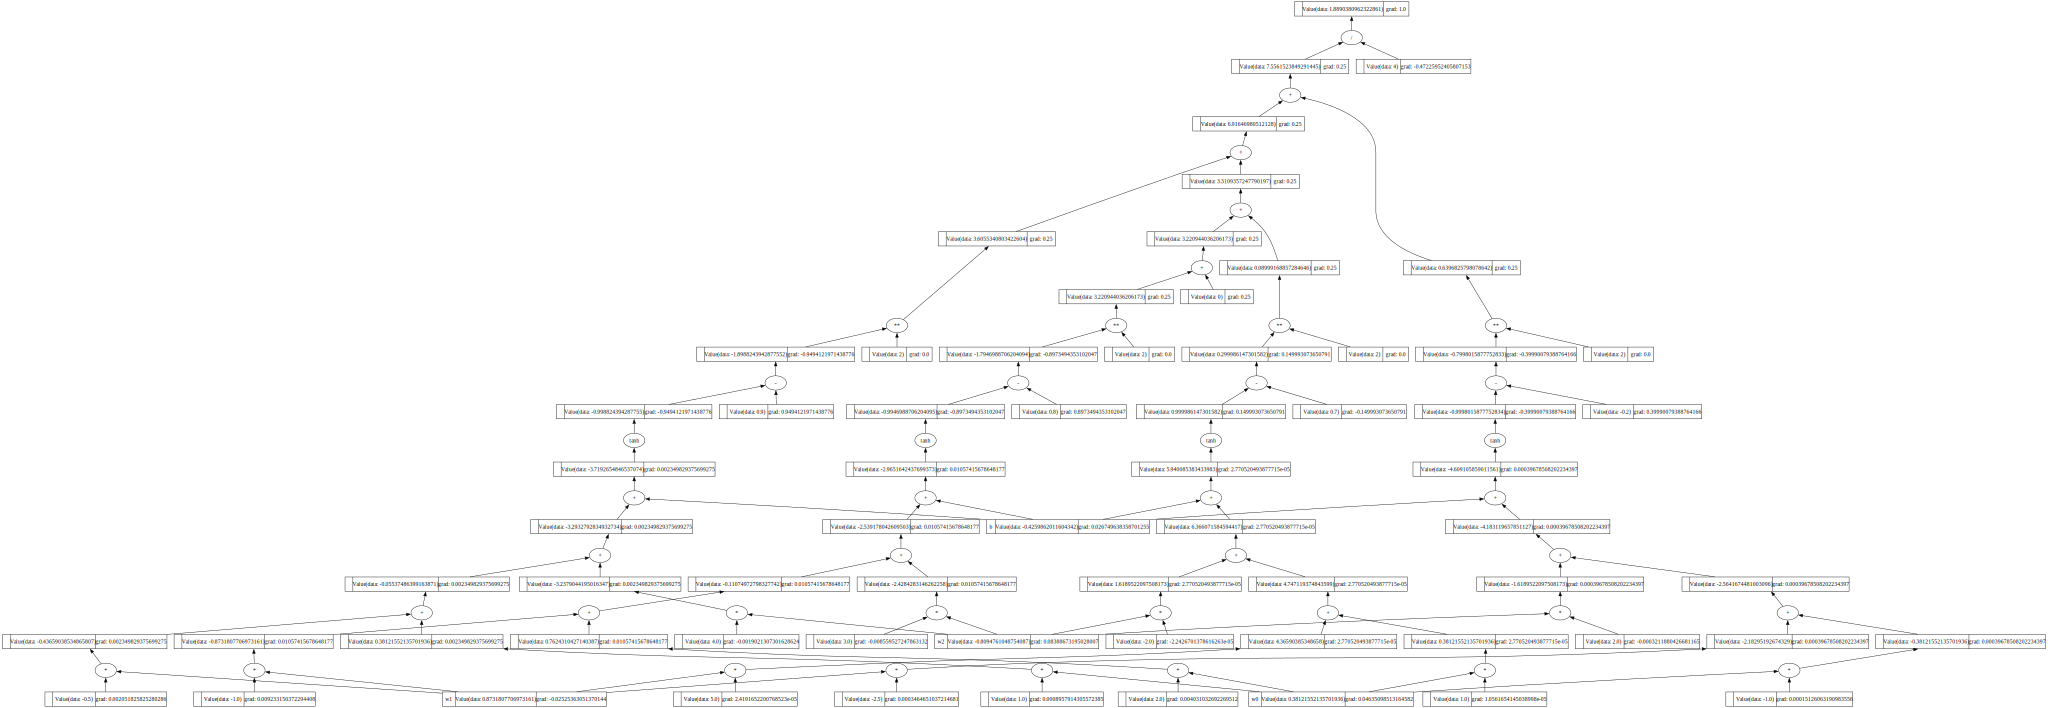

In [467]:
y_hat = []

for x in X:
    y_hat.append(forward(x, W, b))

l = mse_loss(y_hat, y)
l.backward()
dot = viz.generate_graph(l)
dot

In [ ]:


class Linear:
    def __init__(self):
        self.w0 = Value(random.random(), label='w0')
        self.b0 = Value(0, label='b0')
        self.w1 = Value(random.random(), label='w1')
        self.b1 = Value(0, label='b1')
        self.w2 = Value(random.random(), label='w2')
        self.b2 = Value(0, label='b2')


def linear(X):
    y_hat = []
    for x in X:
        o = w0 * x[0] + b + w1